In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from re import search

Preliminary Analysis

Importing the dataset

In [2]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
df = pd.read_csv(os.path.join(dataset_dir,'BuzzFeed Dataset.csv'))

In [ ]:
df_true = pd.read_csv(os.path.join(dataset_dir,'BuzzFeed_real_news_content.csv'))
df_false = pd.read_csv(os.path.join(dataset_dir,'BuzzFeed_fake_news_content.csv'))

In [ ]:
print("True Dataset shape:", df_true.shape)
print("Fake Dataset shape:", df_false.shape)

In [ ]:
df_true.head()

In [ ]:
df_false.head()

In [ ]:
unnamed_columns = [col for col in df_true.columns if search(r'^Unnamed', col)]

df_true = df_true.drop(unnamed_columns, axis=1)

df_true.head()

In [ ]:
unnamed_columns = [col for col in df_false.columns if search(r'^Unnamed', col)]

df_false = df_false.drop(unnamed_columns, axis=1)

df_false.head()

In [ ]:
df_true = df_true.drop(columns=df_true.columns.difference(['id','title','text','authors']))
df_true.shape

In [ ]:
df_false = df_false.drop(columns=df_false.columns.difference(['id','title','text','authors']))
df_false.shape

In [ ]:
df_true['label']=0
df_true.head()

In [ ]:
df_false['label']=1
df_false.head()

In [ ]:
df = pd.concat([df_true, df_false], axis=0)
df = df.sample(frac=1, random_state=1973)
df.head()

In [3]:
print("Dataset shape:", df.shape)

Dataset shape: (101, 4)


In [4]:
news = 'text'
headline = 'title'

Cleaning the data

Checking for missing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      101 non-null    object
 1   text    101 non-null    object
 2   title   101 non-null    object
 3   label   101 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.3+ KB


In [6]:
df.label.value_counts()

0    53
1    48
Name: label, dtype: int64

This confirms that 0 label is used for true news and 1 label is used for fake news

In [7]:
print('Dataset null values:\n',df.isna().sum())

Dataset null values:
 id       0
text     0
title    0
label    0
dtype: int64


In [ ]:
def show_tf_distribution(df, column) :
    null = df[df[column].isna()]
    total = len(null)
    notfake_cnt = list(null[null['label']==0].shape)[0]
    fake_cnt = list(null[null['label']==1].shape)[0]
    
    print('Null Values distribution for \''+column+'\' on basis for realness')
    print('Total:\t',total)
    print('Real %:\t',format(((notfake_cnt/total)*100),'.2f'))
    print('Fake %:\t',format(((fake_cnt/total)*100),'.2f'))

In [ ]:
show_tf_distribution(df, news)

In [ ]:
show_tf_distribution(df, headline)

As every instance of missing value almost always indicates a fake news article, missing value/information can be an identifying factor. Hence not dropping rows with null values.

Checking for placeholder values and duplicates

In [8]:
headline_value_counts = df[headline].value_counts()
headline_value_counts[headline_value_counts > 1]

Series([], Name: title, dtype: int64)

In [9]:
duplicate_headline_list = set(headline_value_counts[headline_value_counts > 1].keys())
df_dup_headline = df[df[headline].isin(duplicate_headline_list)]
df_dup_headline

,id,text,title,label


In [10]:
df_dup_headline[df_dup_headline.duplicated()]

,id,text,title,label


There are no duplicated rows that needs to be deleted

In [11]:
df_dup_headline[df_dup_headline.duplicated([news])]

,id,text,title,label


There are 4 rows with duplicated text

In [12]:
df_dup_headline[df_dup_headline.duplicated([headline, news])]

,id,text,title,label


There are 4 rows with both headlines and news duplicated. These needs to be removed.

In [13]:
df_dup_headline[df_dup_headline[news] == ' ']

,id,text,title,label


We can leave duplicate headlines as that is a common part of news when it undergoes revision but those instances where both headline and news articles are same needs to be dropped. Rows without news will also be removed.

Checking news for whitespaces.

In [14]:
df[df[news] == ' ']

,id,text,title,label


Replacing white spaces with null.

In [15]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [16]:
df.isna().sum()

id       0
text     0
title    0
label    0
dtype: int64

This shows that there is increase in null values in column news as we replace articles that only had null values.

In [ ]:
show_tf_distribution(df, news)

The distribution shows that all null news values still point to fake news. As these values are small compared to total dataset size, dropping them might be preferable.

Removing Duplicated Data

In [18]:
len(df)

101

Dropping rows with no news article or headlines

In [19]:
df_clean = df.dropna(subset=[headline,news])

In [20]:
len(df_clean)

101

Dropping rows with same headline and news articles

In [21]:
df_clean = df_clean.drop_duplicates([headline, news], ignore_index=True)

In [22]:
len(df_clean)

101

Dropping rows with same news articles

In [23]:
df_clean = df_clean.drop_duplicates([news], ignore_index=True)

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      101 non-null    object
 1   text    101 non-null    object
 2   title   101 non-null    object
 3   label   101 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.3+ KB


In [25]:
df_clean.isna().sum()

id       0
text     0
title    0
label    0
dtype: int64

In [26]:
len(df) - len(df_clean)

0

In [27]:
df_clean.label.value_counts()

0    53
1    48
Name: label, dtype: int64

Summary

0 rows of data removed on basis of not having information in news column, headline column and or having duplicate values.

Exploring the dataset

Helper Function

In [28]:
graph_dir = os.path.join(cwd,'Graphs')

In [29]:
def show_hist_for_col(df, column, title):
    """
    Display a histogram for a column in a dataframe, splitting the data by label.
    """
    plt.figure(figsize=(12,8))
    df[df.label == 0][column].hist(label='True')
    df[df.label == 1][column].hist(alpha=0.4, label='Fake')
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
    plt.show()
    plt.close()

Distribution of Labels

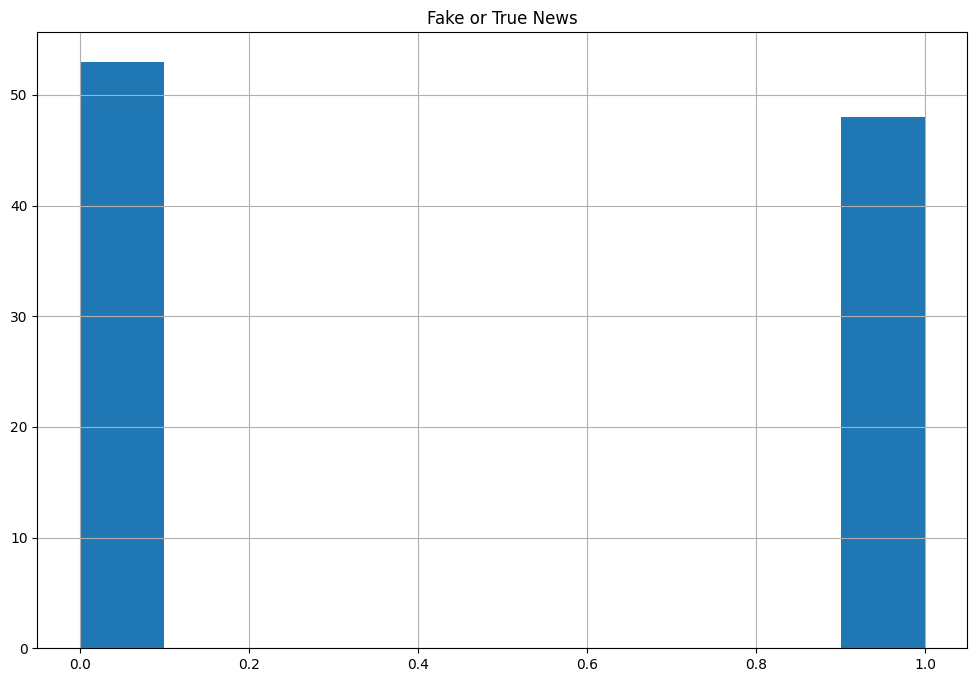

In [30]:
plt.figure(figsize=(12,8))
df_clean.label.hist()
title = 'Fake or True News'
plt.title(title)
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

After cleaning the data there is an imbalance present but hopefully not enough to have effect on the models

Length of Headlines

In [31]:
df_clean['headline_len'] = df_clean[headline].str.len()

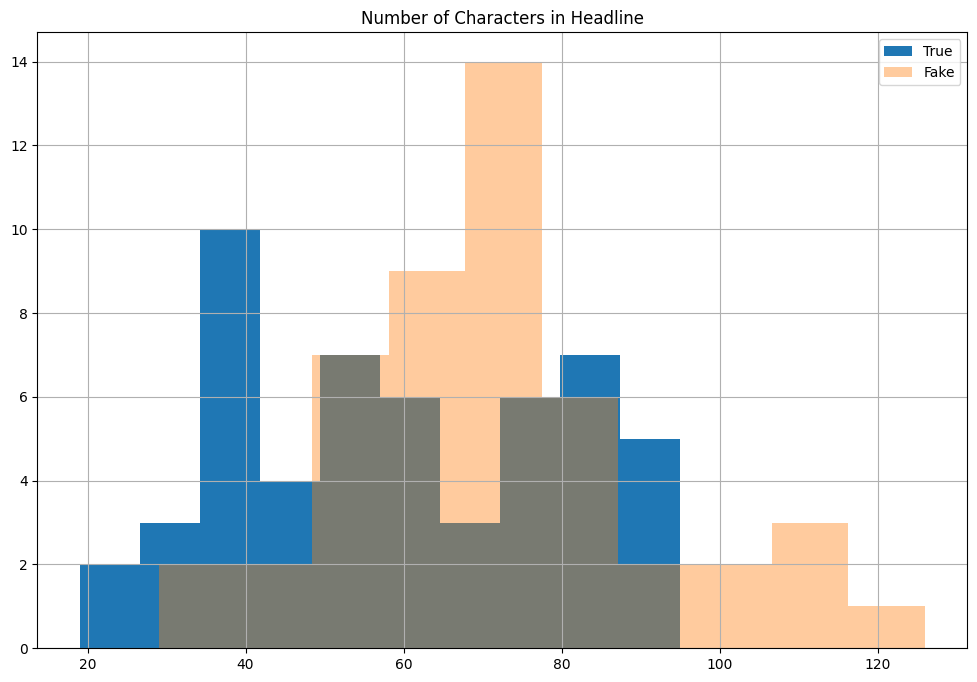

In [32]:
show_hist_for_col(df_clean, 'headline_len', 'Number of Characters in Headline')

In [33]:
df_clean[df_clean.label == 0].headline_len.describe()

count    53.000000
mean     59.490566
std      20.620772
min      19.000000
25%      41.000000
50%      59.000000
75%      79.000000
max      95.000000
Name: headline_len, dtype: float64

In [34]:
df_clean[df_clean.label == 1].headline_len.describe()

count     48.0000
mean      71.5000
std       20.3135
min       29.0000
25%       60.7500
50%       71.0000
75%       78.7500
max      126.0000
Name: headline_len, dtype: float64

Fake news stories have a wider range in the length of title than True news stories. The quartile differences between fake news articles is much larger than in case of true news article.

Length of News article

In [35]:
df_clean['news_len'] = df_clean[news].str.len()

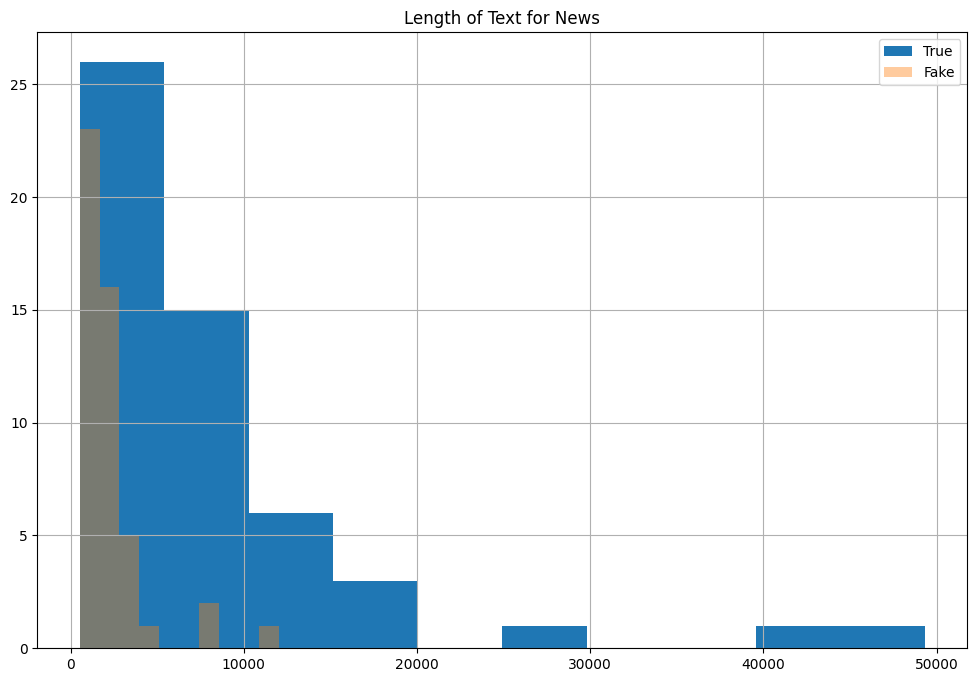

In [36]:
show_hist_for_col(df_clean, 'news_len', 'Length of Text for News')

In [37]:
df_clean[df_clean.label == 0].news_len.describe()

count       53.000000
mean      8433.018868
std       9342.344685
min        520.000000
25%       3703.000000
50%       5659.000000
75%       9835.000000
max      49332.000000
Name: news_len, dtype: float64

In [38]:
df_clean[df_clean.label == 1].news_len.describe()

count       48.000000
mean      2350.479167
std       2056.558393
min        519.000000
25%       1282.000000
50%       1731.000000
75%       2468.250000
max      12025.000000
Name: news_len, dtype: float64

In [39]:
df_long = df_clean[df_clean.news_len > 10000]

In [40]:
df_long

,id,text,title,label,headline_len,news_len
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675
14,103_Real.txt,All politicians bend the truth to fit their pu...,A Week of Whoppers From Donald Trump\n,0,37,10705
25,7_Fake.txt,"Khizr Khan, the Muslim Gold Star father that t...","""Clinton Cash Khizr Khan's Deep Legal Financia...",1,116,12025
34,116_Real.txt,"Tonight, Donald J. Trump accepted the Republic...",Donald Trump's nomination is the first time Am...,0,87,15323
40,101_Real.txt,The list of Republicans supporting Hillary Cli...,78 Republican politicians donors and officials...,0,82,13677
41,131_Real.txt,Let us now address the greatest American myste...,Millions of ordinary Americans support Donald ...,0,64,12815
56,110_Real.txt,"I like authenticity, especially as compared to...",Donald Trump 'If I lose I don't think you will...,0,66,28707
67,104_Real.txt,m cool with you removing me from your friends ...,An Open Letter to My Friends Who Support Donal...,0,54,10832
76,123_Real.txt,It seems were entering another of those stupid...,History Tells Us What Will Happen Next With Br...,0,61,14163
92,141_Real.txt,There is a smug style in American liberalism. ...,The smug style in American liberalism\n,0,38,43353


In [41]:
df_long.label.value_counts()

0    12
1     1
Name: label, dtype: int64

ok there does not seem to be bias in long stories towards either type of articles so they will be kept. also fake news article have shown much higher max story size and significantly lower quartile scores across the board.

Capital letters in headline.

In [42]:
df_clean['caps_in_headline'] = df_clean[headline].apply(lambda headline: sum(1 for char in headline if char.isupper()))

In [43]:
df_clean

,id,text,title,label,headline_len,news_len,caps_in_headline
0,107_Real.txt,See Liberal Facebook and Conservative Facebook...,Blue Feed Red Feed\n,0,19,1151,4
1,125_Real.txt,Contrary to the conventional wisdom saying tha...,"""It's Official """"Bernie Sanders Is Staying In ...",0,79,7740,13
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14
3,153_Real.txt,"It came together in about a week. First, the i...",Pantsuit Power flashmob video for Hillary Clin...,0,86,5102,5
4,115_Real.txt,Donald Trumps new campaign manager once insist...,Donald Trump's campaign manager says rape woul...,0,81,2068,2
...,...,...,...,...,...,...,...
96,28_Fake.txt,"WASHINGTON, D.C. \n\nFormer presidential inte...",Monica Lewinsky Says She Is Voting For Hillary...,1,55,1013,9
97,113_Real.txt,Donald Trump is going to be elected president....,Donald Trump Is Going To Be Elected\n,0,36,3682,7
98,132_Real.txt,"Park City, Utah (CNN)Mitt Romney suggested Fri...",Mitt Romney says Donald Trump will change Amer...,0,76,7593,5
99,139_Real.txt,"The American media, over the past year, has be...",The rise of American authoritarianism\n,0,38,49332,2


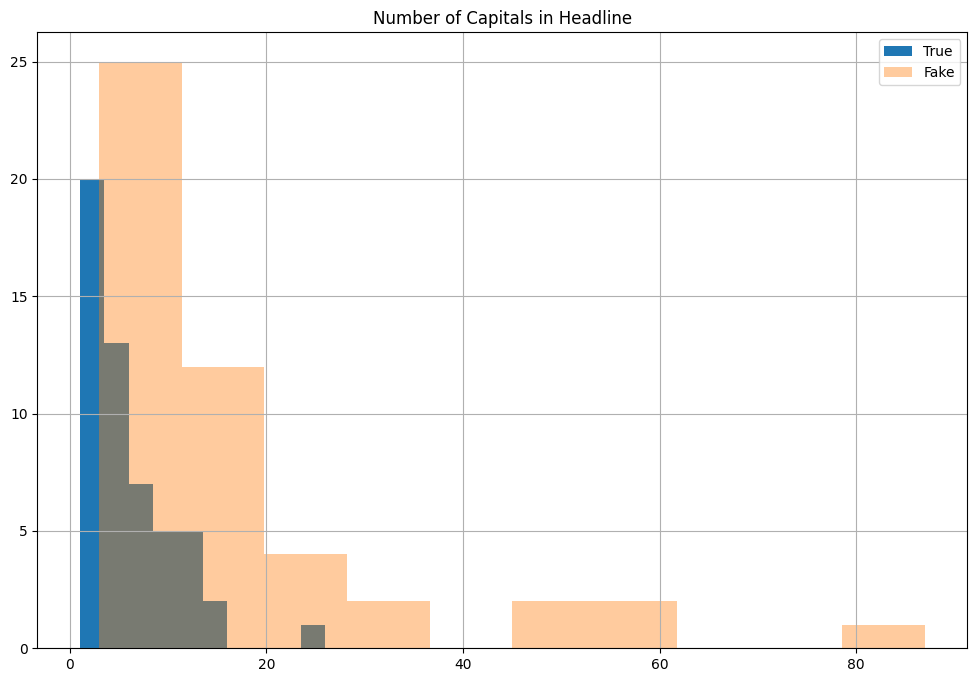

In [44]:
show_hist_for_col(df_clean, 'caps_in_headline', 'Number of Capitals in Headline')

In [45]:
df_clean[df_clean.label == 0].caps_in_headline.describe()

count    53.000000
mean      6.018868
std       4.538259
min       1.000000
25%       3.000000
50%       4.000000
75%       8.000000
max      26.000000
Name: caps_in_headline, dtype: float64

In [46]:
df_clean[df_clean.label == 1].caps_in_headline.describe()

count    48.000000
mean     16.979167
std      16.489184
min       3.000000
25%       9.000000
50%      10.500000
75%      18.250000
max      87.000000
Name: caps_in_headline, dtype: float64

There is much more deviation in number of Capital letter in headline in fake news articles. also fake news articles have much more amount of Capital letter in headline.

In [47]:
df_clean['norm_caps_in_headline'] = df_clean['caps_in_headline'] / df_clean['headline_len']

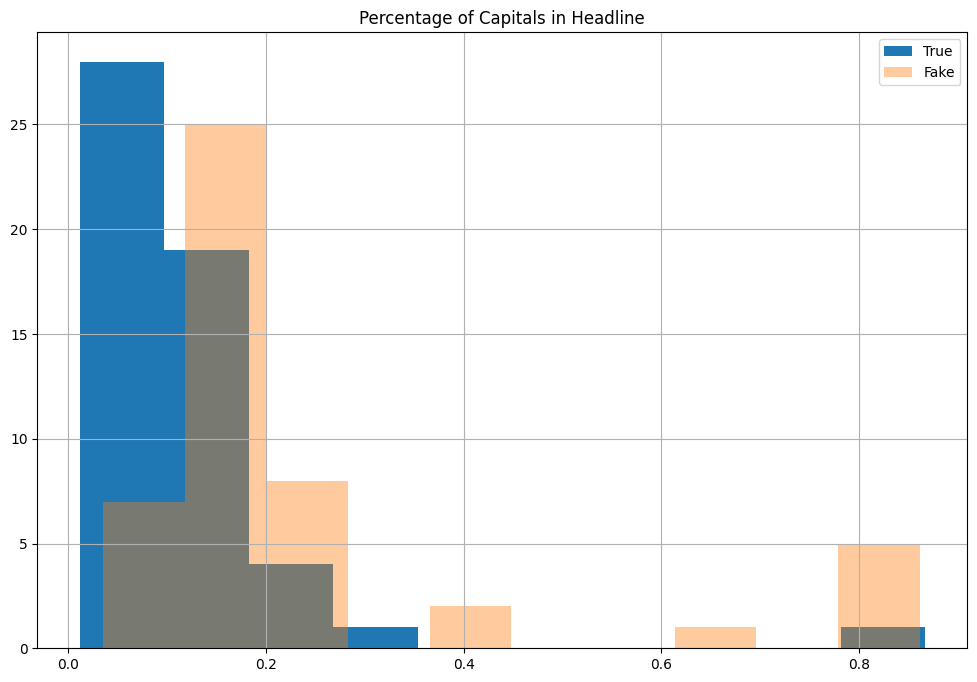

In [48]:
show_hist_for_col(df_clean, 'norm_caps_in_headline', 'Percentage of Capitals in Headline')

In [49]:
df_clean[df_clean.label == 0].norm_caps_in_headline.describe()

count    53.000000
mean      0.117381
std       0.122373
min       0.011364
25%       0.052632
50%       0.076923
75%       0.164557
max       0.866667
Name: norm_caps_in_headline, dtype: float64

In [50]:
df_clean[df_clean.label == 1].norm_caps_in_headline.describe()

count    48.000000
mean      0.246332
std       0.229212
min       0.034884
25%       0.135005
50%       0.162175
75%       0.235184
max       0.861386
Name: norm_caps_in_headline, dtype: float64

percentage of capitals may be useful as even first quartile of percentage of capitals in fake news is larger than even third quartile in true news article. but this might not be generalizable

Capital in news article

In [51]:
df_clean['caps_in_news'] = df_clean[news].apply(lambda news: sum(1 for char in news if char.isupper()))

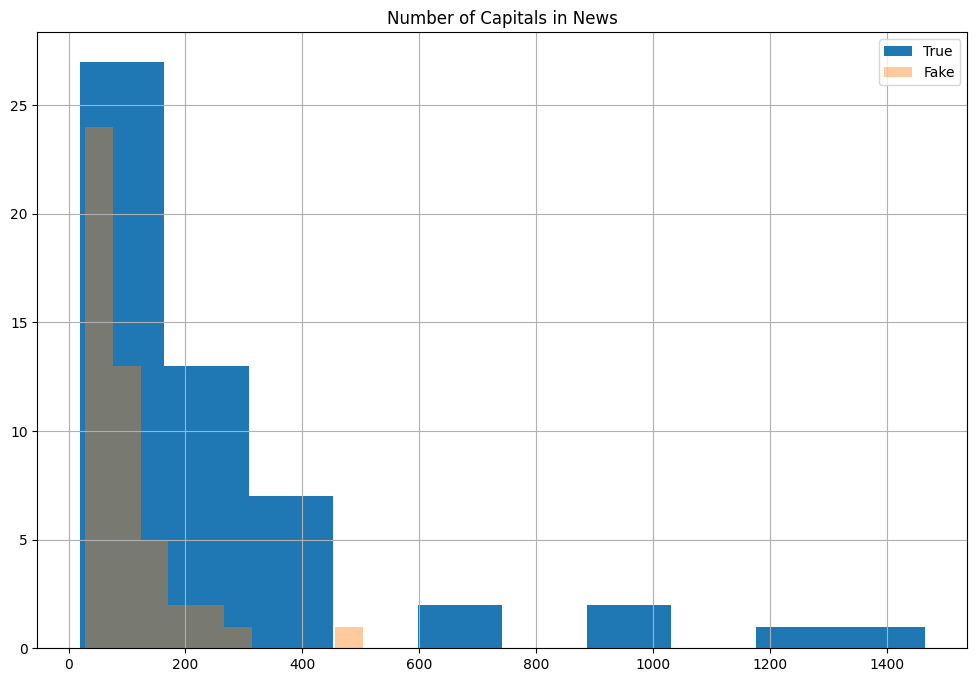

In [52]:
show_hist_for_col(df_clean, 'caps_in_news', 'Number of Capitals in News')

In [53]:
df_clean[df_clean.label == 0].caps_in_news.describe()

count      53.000000
mean      267.660377
std       298.024840
min        19.000000
25%       107.000000
50%       159.000000
75%       307.000000
max      1465.000000
Name: caps_in_news, dtype: float64

In [54]:
df_clean[df_clean.label == 1].caps_in_news.describe()

count     48.000000
mean      96.937500
std       82.735263
min       28.000000
25%       49.750000
50%       75.500000
75%      101.000000
max      504.000000
Name: caps_in_news, dtype: float64

In [55]:
df_clean['norm_caps_in_news'] = df_clean['caps_in_news'] / df_clean['news_len']

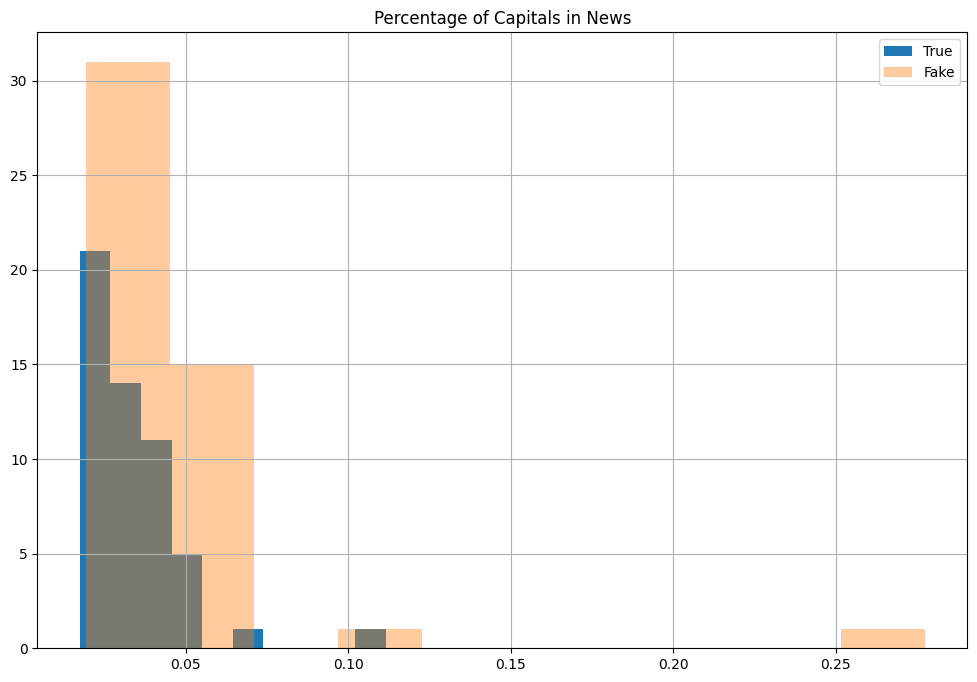

In [56]:
show_hist_for_col(df_clean, 'norm_caps_in_news', 'Percentage of Capitals in News')

In [57]:
df_clean[df_clean.label == 0].norm_caps_in_news.describe()

count    53.000000
mean      0.033688
std       0.015386
min       0.017287
25%       0.024733
50%       0.029511
75%       0.037954
max       0.111537
Name: norm_caps_in_news, dtype: float64

In [58]:
df_clean[df_clean.label == 1].norm_caps_in_news.describe()

count    48.000000
mean      0.046219
std       0.037564
min       0.019192
25%       0.032863
50%       0.039331
75%       0.048854
max       0.277457
Name: norm_caps_in_news, dtype: float64

There is a lot of overlap in number of capitals in news article between fake and real news.

In [59]:
def check_string_for(substring, fullstring):
    """Check if the substring is in the fullstring"""
    if search(substring, fullstring):
        return True
    else:
        return False

Via and Image Via in article

In [60]:
df_via = df_clean[df_clean[news].apply(lambda news_text: check_string_for(' via', news_text))]

In [61]:
df_via

,id,text,title,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
1,125_Real.txt,Contrary to the conventional wisdom saying tha...,"""It's Official """"Bernie Sanders Is Staying In ...",0,79,7740,13,0.164557,307,0.039664
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14,0.181818,376,0.027495
5,150_Real.txt,"I dont know about you, but Im getting tired of...",Why Do We Hear More About Hillary's Emails Tha...,0,80,4360,13,0.162500,91,0.020872
38,102_Real.txt,CLEVELAND Avik Roy is a Republicans Republica...,A Republican intellectual explains why the Rep...,0,76,9835,4,0.052632,350,0.035587
40,101_Real.txt,The list of Republicans supporting Hillary Cli...,78 Republican politicians donors and officials...,0,82,13677,3,0.036585,723,0.052862
75,117_Real.txt,Conservatives efforts to recruit a candidate t...,Dwayne Johnson says he might want to run for p...,0,79,3947,3,0.037975,101,0.025589
90,9_Fake.txt,"Indianapolis, IN Some are calling Donald Trum...",Donald Trump Bombshell Ted Cruz's Wife Former ...,1,56,1888,9,0.160714,92,0.048729
94,138_Real.txt,"Some time ago, Hillary Clinton and her adviser...",The real Clinton email scandal is that a bulls...,0,83,19838,2,0.024096,436,0.021978


In [62]:
df_via['label'].value_counts()

0    7
1    1
Name: label, dtype: int64

Via is much more indicative of fake news article compared to true news article.

In [63]:
df_image_via = df_clean[df_clean[news].apply(lambda news_text: check_string_for('image via', news_text))]

In [64]:
df_image_via

,id,text,title,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news


In [65]:
df_image_via['label'].value_counts()

Series([], Name: label, dtype: int64)

With all the posts with image via being Fake, it's highly indicative of that label, but this may be particular to this dataset and may not generalize.

Said in news article

In [66]:
df_said = df_clean[df_clean[news].apply(lambda news_text: check_string_for('said', news_text))]

In [67]:
df_said

,id,text,title,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14,0.181818,376,0.027495
4,115_Real.txt,Donald Trumps new campaign manager once insist...,Donald Trump's campaign manager says rape woul...,0,81,2068,2,0.024691,94,0.045455
6,142_Real.txt,"These celebrities had some, uh, extreme respon...",These Celebrities Say They'd Leave the Country...,0,61,744,9,0.147541,39,0.052419
11,108_Real.txt,(CNN)The Democratic National Convention kicked...,Dems open convention without Wasserman Schultz\n,0,47,9893,3,0.063830,409,0.041342
12,106_Real.txt,Former first lady Barbara Bush said Friday tha...,Barbara Bush I don’t know how women can vote f...,0,55,803,4,0.072727,37,0.046077
...,...,...,...,...,...,...,...,...,...,...
95,19_Fake.txt,Theres no telling how many times during the ca...,Hey Hillary thanks for telling the world Ameri...,1,86,3106,3,0.034884,180,0.057952
96,28_Fake.txt,"WASHINGTON, D.C. \n\nFormer presidential inte...",Monica Lewinsky Says She Is Voting For Hillary...,1,55,1013,9,0.163636,36,0.035538
97,113_Real.txt,Donald Trump is going to be elected president....,Donald Trump Is Going To Be Elected\n,0,36,3682,7,0.194444,188,0.051059
98,132_Real.txt,"Park City, Utah (CNN)Mitt Romney suggested Fri...",Mitt Romney says Donald Trump will change Amer...,0,76,7593,5,0.065789,276,0.036349


In [68]:
df_said['label'].value_counts()

0    36
1    26
Name: label, dtype: int64

The stories containing the word said are indicative of the news story being true. With twice as many of the "true" news stories containing said vs. "fake", the true ones must seem likely to be more concerned with providing quotations, or at least quotations in this style.

On in news article

In [69]:
df_on = df_clean[df_clean[news].apply(lambda news_text: check_string_for(' on ', news_text))]

In [70]:
df_on

,id,text,title,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
0,107_Real.txt,See Liberal Facebook and Conservative Facebook...,Blue Feed Red Feed\n,0,19,1151,4,0.210526,32,0.027802
1,125_Real.txt,Contrary to the conventional wisdom saying tha...,"""It's Official """"Bernie Sanders Is Staying In ...",0,79,7740,13,0.164557,307,0.039664
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14,0.181818,376,0.027495
3,153_Real.txt,"It came together in about a week. First, the i...",Pantsuit Power flashmob video for Hillary Clin...,0,86,5102,5,0.058140,186,0.036456
4,115_Real.txt,Donald Trumps new campaign manager once insist...,Donald Trump's campaign manager says rape woul...,0,81,2068,2,0.024691,94,0.045455
...,...,...,...,...,...,...,...,...,...,...
96,28_Fake.txt,"WASHINGTON, D.C. \n\nFormer presidential inte...",Monica Lewinsky Says She Is Voting For Hillary...,1,55,1013,9,0.163636,36,0.035538
97,113_Real.txt,Donald Trump is going to be elected president....,Donald Trump Is Going To Be Elected\n,0,36,3682,7,0.194444,188,0.051059
98,132_Real.txt,"Park City, Utah (CNN)Mitt Romney suggested Fri...",Mitt Romney says Donald Trump will change Amer...,0,76,7593,5,0.065789,276,0.036349
99,139_Real.txt,"The American media, over the past year, has be...",The rise of American authoritarianism\n,0,38,49332,2,0.052632,1008,0.020433


In [71]:
df_on.label.value_counts()

0    51
1    38
Name: label, dtype: int64

The use of 'on' is fairly balanced although somewhat indicative of a 'true' story.

You in news article

In [72]:
df_you = df_clean[df_clean[news].apply(lambda news_text: check_string_for(' you ', news_text))]

In [73]:
df_you

,id,text,title,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
1,125_Real.txt,Contrary to the conventional wisdom saying tha...,"""It's Official """"Bernie Sanders Is Staying In ...",0,79,7740,13,0.164557,307,0.039664
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14,0.181818,376,0.027495
3,153_Real.txt,"It came together in about a week. First, the i...",Pantsuit Power flashmob video for Hillary Clin...,0,86,5102,5,0.058140,186,0.036456
5,150_Real.txt,"I dont know about you, but Im getting tired of...",Why Do We Hear More About Hillary's Emails Tha...,0,80,4360,13,0.162500,91,0.020872
8,122_Real.txt,"In any normal election year, wed compare the t...",HILLARY CLINTON FOR PRESIDENT\n,0,30,2265,26,0.866667,54,0.023841
...,...,...,...,...,...,...,...,...,...,...
96,28_Fake.txt,"WASHINGTON, D.C. \n\nFormer presidential inte...",Monica Lewinsky Says She Is Voting For Hillary...,1,55,1013,9,0.163636,36,0.035538
97,113_Real.txt,Donald Trump is going to be elected president....,Donald Trump Is Going To Be Elected\n,0,36,3682,7,0.194444,188,0.051059
98,132_Real.txt,"Park City, Utah (CNN)Mitt Romney suggested Fri...",Mitt Romney says Donald Trump will change Amer...,0,76,7593,5,0.065789,276,0.036349
99,139_Real.txt,"The American media, over the past year, has be...",The rise of American authoritarianism\n,0,38,49332,2,0.052632,1008,0.020433


In [74]:
df_you.label.value_counts()

0    38
1    24
Name: label, dtype: int64

You is present in both true and fake news stories with a bit more mention in fake news stories which might be due to a more informal writing approach.

In [75]:
df_clean = df_clean.rename(columns={'title': 'headline'})
df_clean = df_clean.rename(columns={'text': 'news'})
df_clean.head()

,id,news,headline,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
0,107_Real.txt,See Liberal Facebook and Conservative Facebook...,Blue Feed Red Feed\n,0,19,1151,4,0.210526,32,0.027802
1,125_Real.txt,Contrary to the conventional wisdom saying tha...,"""It's Official """"Bernie Sanders Is Staying In ...",0,79,7740,13,0.164557,307,0.039664
2,152_Real.txt,An anonymous Jane Doe filed a federal lawsuit ...,Why The New Child Rape Case Filed Against Dona...,0,77,13675,14,0.181818,376,0.027495
3,153_Real.txt,"It came together in about a week. First, the i...",Pantsuit Power flashmob video for Hillary Clin...,0,86,5102,5,0.058140,186,0.036456
4,115_Real.txt,Donald Trumps new campaign manager once insist...,Donald Trump's campaign manager says rape woul...,0,81,2068,2,0.024691,94,0.045455


Save the Cleaned Dataset

In [76]:
df_clean.to_csv(os.path.join(dataset_dir,'train_news_cleaned.csv'),index=False)